# Utilities

In [1]:
truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000

In [2]:
import numpy as np
from numba import jit
@jit(nopython=True)
def _numba_peak_detection_single(waveform, d2, T1, T2):
    """Numba-compiled inner loop for single waveform processing."""
    n = len(waveform)
    peaks = []
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
            
        if d2[i] > 0:
            Int[i] = Int[i-1] + d2[i]
        elif Int[i-1] > T2:
            peaks.append(i-1)
            Int[i] = 0.0
        else:
            Int[i] = 0.0

    return peaks


def numba_batched_derivative_peak_detection(waveforms, T1, T2):
    """
    Numba-accelerated derivative-based peak detection for multiple waveforms.
    
    Args:
    waveforms (np.array): 2D array where each row is a waveform (shape: [n_waveforms, n_points])
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: List of detected peak indices for each waveform.
    """
    if len(waveforms.shape) == 1:
        waveforms = waveforms.reshape(1, -1)
    
    n_waveforms, n_points = waveforms.shape
    
    # Vectorized computation of derivatives
    D1 = np.zeros_like(waveforms)
    D1[:,1:] = np.maximum(np.diff(waveforms, axis=1), 0)
    mask = waveforms[:,:-1] < T1
    D1[:,1:][mask] = 0

    D2 = np.zeros_like(waveforms)
    D2[:,1:] = np.maximum(np.diff(D1, axis=1), 0)
    
    # Process each waveform using Numba
    all_peaks = []
    for w_idx in range(n_waveforms):
        peaks = _numba_peak_detection_single(waveforms[w_idx], D2[w_idx], T1, T2)
        all_peaks.append(list(peaks))  # Convert from numba list to Python list
    
    return all_peaks

In [3]:
# import numpy as np
# from numba import jit
# @jit(nopython=True)
# def _numba_peak_detection_single(waveform, d2, T1, T2):
#     """Numba-compiled inner loop for single waveform processing."""
#     n = len(waveform)
#     peaks = []
#     Int = 0.0
    
#     for i in range(1, n):
#         if waveform[i-1] < T1:
#             Int = 0.0
#             continue
            
#         if d2[i] > 0:
#             Int += d2[i]
#         elif Int > T2:
#             peaks.append(i-1)
#             Int = 0.0
#         else:
#             Int = 0.0
    
#     return peaks


# def numba_batched_derivative_peak_detection(waveforms, T1, T2):
#     """
#     Numba-accelerated derivative-based peak detection for multiple waveforms.
    
#     Args:
#     waveforms (np.array): 2D array where each row is a waveform (shape: [n_waveforms, n_points])
#     T1 (float): Threshold for initial amplitude check.
#     T2 (float): Threshold for integrated second derivative.
    
#     Returns:
#     list: List of detected peak indices for each waveform.
#     """
#     if len(waveforms.shape) == 1:
#         waveforms = waveforms.reshape(1, -1)
    
#     n_waveforms, n_points = waveforms.shape
    
#     # Vectorized computation of derivatives
#     D1 = np.zeros_like(waveforms)
#     D1[:, 1:] = np.maximum(np.diff(waveforms, axis=1), 0)
    
#     D2 = np.zeros_like(waveforms)
#     D2[:, 1:] = np.maximum(np.diff(D1, axis=1), 0)
    
#     # Process each waveform using Numba
#     all_peaks = []
#     for w_idx in range(n_waveforms):
#         peaks = _numba_peak_detection_single(waveforms[w_idx], D2[w_idx], T1, T2)
#         all_peaks.append(list(peaks))  # Convert from numba list to Python list
    
#     return all_peaks



In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

def load_data(dir, files):
    # Dictionary to store lists of arrays for each key
    combined_data = {}

    # Loop through files and collect arrays
    for filename in files:
        origdata = np.load(dir+filename)
        for key in origdata.files:
            if key not in combined_data:
                combined_data[key] = []
            combined_data[key].append(origdata[key])

    # Concatenate arrays along the first axis for each key
    return {key: np.concatenate(arr_list, axis=0) for key, arr_list in combined_data.items()}


# How to use the D2 Algorithm function:
# Set your thresholds (these need to be tuned based on the specific data)
# T1 = 3 * np.std(data['wf_i'][1][2500:2900])  # Example: 3 times the std of the noise baseline
# T2 = 0.053320  # This needs to be tuned based on your data

# detected_peaks = process_waveforms(waveforms, T1, T2)

def derivative_peak_detection(waveform, T1, T2):
    """
    Derivative-based peak detection algorithm.
    
    Args:
    waveform (np.array): Input waveform with n points.
    T1 (float): Threshold for initial amplitude check.
    T2 (float): Threshold for integrated second derivative.
    
    Returns:
    list: Indices of detected peaks.
    """
    n = len(waveform)
    Output = []
    D1 = np.zeros(n)
    D2 = np.zeros(n)
    Int = np.zeros(n)
    
    for i in range(1, n):
        if waveform[i-1] < T1:
            continue
        
        D1[i] = max(waveform[i] - waveform[i-1], 0)
        D2[i] = max(D1[i] - D1[i-1], 0)
        
        if D2[i] > 0:
            Int[i] = Int[i-1] + D2[i]
        elif Int[i-1] > T2:
            Output.append(i-1)
            Int[i] = 0  # Reset integration after detecting a peak
        else:
            Int[i] = 0  # Reset integration if no peak detected

    return Output


def process_waveforms(waveforms, T1, T2):
    """
    Process multiple waveforms using the derivative algorithm.

    Returns:
        list: List of detected peak indices for each waveform.
    """
    all_peaks = []
    for waveform in tqdm(waveforms, desc="Processing waveforms", unit="waveform"):
        peaks = derivative_peak_detection(waveform, T1, T2)
        all_peaks.append(peaks)
    return all_peaks

def d1_peak_detection(waveform, t1, t2):
    """
    D1 algorithm for real-time peak detection.
    
    Args:
        waveform (np.array): Input waveform with n points.
        t1 (float): Threshold for short-term gradient V(i+1) - V(i).
        t2 (float): Threshold for medium-term gradient V(i+2) - V(i).
    
    Returns:
        int: Number of detected peaks.
    """
    n = len(waveform)
    
    peak_count = 0
    in_peak = False
    
    # Process each point in real-time fashion
    for i in range(n - 2):  # We need i+2 to be valid
        # Calculate gradients
        short_gradient = waveform[i + 1] - waveform[i]
        medium_gradient = waveform[i + 2] - waveform[i]
        
        # Determine signal (1 or 0)
        signal = 1 if (short_gradient > t1 or medium_gradient > t2) else 0
        
        # Peak detection logic
        if signal == 1 and not in_peak:
            # Start of a new peak
            in_peak = True
        elif signal == 0 and in_peak:
            # End of current peak
            in_peak = False
            peak_count += 1
    
    # Handle case where waveform ends while in a peak
    if in_peak:
        peak_count += 1
    
    return peak_count

def process_waveforms_d1(waveforms, t1, t2):
    """
    Process multiple waveforms using the D1 algorithm.
    
    Args:
        waveforms: Array of waveforms to process.
        t1 (float): Threshold for short-term gradient.
        t2 (float): Threshold for medium-term gradient.
    
    Returns:
        list: List of detected peak counts for each waveform.
    """
    peak_counts = []
    # for waveform in tqdm(waveforms, desc="Processing waveforms with D1", unit="waveform"):
    for waveform in waveforms:
        count = d1_peak_detection(waveform, t1, t2)
        peak_counts.append(count)
    return peak_counts

# Extract true peaks from labels

def extract_true_peaks_from_labels(testdata):
    """
    Extract true peak positions from labels where tag_values = 1 or 2.
    
    Returns:
        list: List of true peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1 and 2
        peak_mask = (tag_values[i] == 1) | (tag_values[i] == 2)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

def extract_true_primary_peaks_from_labels(testdata):
    """
    Extract true primary peak positions from labels where tag_values = 1.
    
    Returns:
        list: List of true primary peak time values for each waveform.
    """
    tag_values = testdata['tag_values']
    tag_times = testdata['tag_times']
    
    all_true_peaks = []
    
    print("Extracting true primary peaks from labels (vectorized)...")
    
    for i in tqdm(range(len(tag_values)), desc="Processing waveforms", unit="waveform"):
        # Create mask for tags 1
        peak_mask = (tag_values[i] == 1)
        # Extract corresponding times
        true_peak_times = tag_times[i][peak_mask].tolist()
        
        all_true_peaks.append(true_peak_times)
    
    return all_true_peaks

# Fixed Clusterization Method

def estimate_primary_from_cluster_window(detected_peaks, b, c, d):
    """
    Estimate the number of primary ionizations per waveform by merging nearby peaks in a sliding window.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Number of units to look forward in time window.
        c (float): Normalization factor (divides peak count in window).
        d (float): Maximum number of peaks in window.
    Returns:
        list: Estimated number of primary ionizations (float) for each waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:

        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current
            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d*c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts

def collect_cluster_peaks(detected_peaks, b, c, d):
    """
    For each waveform, return a list of peak lists used in each cluster count step.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b (int): Window size to look forward.
        c (float): Normalization factor.
        d (float): Maximum number of peaks allowed in window.
    
    Returns:
        list of lists: Each inner list contains the peak values used at each cluster step.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]
            window_start = current

            window_end = current + b

            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            # Determine how many peaks to take from this cluster
            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            # Store the first n peaks in this cluster (or fewer if not enough)
            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def find_best_indices_3d(data, mode="mean"):
    if mode == "mean":
        idx = np.unravel_index(np.argmin(np.abs(data)), data.shape)
    elif mode == "std":
        idx = np.unravel_index(np.argmin(data), data.shape)
    return idx

def plot_heatmap_2d_slice(data_3d, d_idx, title, x_labels, y_labels, x_name, y_name, cmap='viridis', highlight=None):
    data = data_3d[:, :, d_idx]
    plt.figure(figsize=(10, 6))
    im = plt.imshow(data, origin='lower', cmap=cmap,
                    extent=[x_labels[0], x_labels[-1], y_labels[0], y_labels[-1]],
                    aspect='auto')

    cbar = plt.colorbar(im, format="%.4f")
    cbar.ax.tick_params(labelsize=10)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f"{title} (d = {d_values[d_idx]})")

    if highlight:
        i, j, _ = highlight
        x_val = x_labels[j]
        y_val = y_labels[i]
        plt.plot(x_val, y_val, 'ro', markersize=8, label='Best Point')
        plt.legend()

    plt.tight_layout()
    plt.show()


# Adaptive Clusterization Method

import itertools

if truncate:
    region_bounds = {
        'r1': (0, 125),
        'r2': (125, 250),
        'r3': (250, 375),
        'r4': (375, 500),
    }

else:
    region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }

# region_bounds = {
    #     'r1': (0, 130),
    #     'r2': (130, 1600),
    #     'r3': (1600, 3000),
    # }

def estimate_primary_from_cluster_window_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Adaptive estimation of primary ionizations per waveform using different parameters for different time regions.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Keys are region names ('r1', 'r2', ...), values are parameter values.
    
    Returns:
        list: Estimated primary ionizations per waveform.
    """
    estimated_counts = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        count = 0.0

        while remaining_peaks:
            current = remaining_peaks[0]

            # Determine region
            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                count += 1
            elif d * c > len(cluster) > c:
                count += len(cluster) / c
            else:
                count += d

            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        estimated_counts.append(count)
    return estimated_counts


def collect_cluster_peaks_adaptive(detected_peaks, b_map, c_map, d_map):
    """
    Collect cluster peaks per waveform with region-adapted parameters.

    Args:
        detected_peaks (list of lists): List of peak positions (indices) per waveform.
        b_map, c_map, d_map (dict): Region-specific parameter mappings.

    Returns:
        list of lists: Each inner list contains peak lists used in each cluster.
    """
    all_cluster_peaks = []

    for peaks in detected_peaks:
        peaks = sorted(peaks)
        remaining_peaks = peaks.copy()
        waveform_clusters = []

        while remaining_peaks:
            current = remaining_peaks[0]

            region = next(r for r, (low, high) in region_bounds.items() if low <= current < high)
            b = b_map[region]
            c = c_map[region]
            d = d_map[region]

            window_start = current
            window_end = current + b
            cluster = [p for p in remaining_peaks if window_start <= p <= window_end]

            if len(cluster) <= c:
                n = 1
            elif d * c > len(cluster) > c:
                n = int(len(cluster) / c)
            else:
                n = int(d)

            waveform_clusters.append(cluster[:n])
            remaining_peaks = [p for p in remaining_peaks if p not in cluster]

        all_cluster_peaks.append(waveform_clusters)

    return all_cluster_peaks

def scan_adaptive_parameters_region_wise(detected_peaks, true_primary_peaks):
    """
    Scan optimal parameters for each region using true primary peaks.
    
    Args:
        detected_peaks (list): List of detected peak positions for each waveform
        true_primary_peaks (list): List of true primary peak positions for each waveform (from extract_true_primary_peaks_from_labels)
    """

    b_values = np.arange(1, 100, 1)
    c_values = np.arange(0.8, 2.0, 0.1)
    d_values = np.arange(1, 6, 1)
    
    best_params = {}
    region_results = {}
    
    for region, (low, high) in region_bounds.items():
        print(f"Scanning parameters for region {region} ({low}-{high})")
        
        region_detected_peaks = []
        region_true_counts = []
        
        for i, peaks in enumerate(detected_peaks):
            region_peaks = [p for p in peaks if low <= p < high]
            true_peaks_in_region = [p for p in true_primary_peaks[i] if low <= p < high]
            true_count_in_region = len(true_peaks_in_region)
            if region_peaks:
                region_detected_peaks.append(region_peaks)
                region_true_counts.append(true_count_in_region)
        
        if not region_detected_peaks:
            best_params[region] = {'b': 10, 'c': 1.0, 'd': 2}
            region_results[region] = float('inf')
            print(f"No detected peaks in region {region}, using default parameters")
            continue
        
        region_true_counts = np.array(region_true_counts)
        
        best_score = float('inf')
        best_region_params = None
        
        for b, c, d in tqdm(list(itertools.product(b_values, c_values, d_values)), 
                           desc=f"Region {region}"):
            
            temp_b_map = {r: 10 for r in region_bounds.keys()}
            temp_c_map = {r: 1.0 for r in region_bounds.keys()}
            temp_d_map = {r: 2 for r in region_bounds.keys()}
            
            temp_b_map[region] = int(b)
            temp_c_map[region] = float(c)
            temp_d_map[region] = int(d)
            
            estimated_counts = []
            for peaks in region_detected_peaks:
                count = estimate_single_region_count(peaks, b, c, d)
                estimated_counts.append(count)
            
            estimated_counts = np.array(estimated_counts)
            
            # Calculate relative errors: (estimated - true) / true
            with np.errstate(divide='ignore', invalid='ignore'):
                relative_errors = (estimated_counts - region_true_counts) / region_true_counts
                # Handle division by zero and invalid values
                relative_errors = relative_errors[np.isfinite(relative_errors)]
            
            # Calculate score based on relative errors
            if len(relative_errors) > 0:
                score = np.abs(np.mean(relative_errors))  # Mean squared relative error
            else:
                score = float('inf')  # If no valid relative errors, set high score
            
            if score < best_score:
                best_score = score
                best_region_params = {'b': b, 'c': c, 'd': d}
                # print(f"Best score: {score:.4f}")
                # print(f"Best params: {best_region_params}")
        
        best_params[region] = best_region_params
        region_results[region] = best_score
        print(f"Best params for {region}: {best_region_params}, Score: {best_score:.4f}")
    
    return best_params, region_results

def estimate_single_region_count(peaks, b, c, d):
    if not peaks:
        return 0.0
    
    peaks = sorted(peaks)
    remaining_peaks = peaks.copy()
    count = 0.0
    
    while remaining_peaks:
        current = remaining_peaks[0]
        window_start = current
        window_end = current + b
        
        cluster = [p for p in remaining_peaks if window_start <= p <= window_end]
        
        if len(cluster) <= c:
            count += 1
        elif d * c > len(cluster) > c:
            count += len(cluster) / c
        else:
            count += d
        
        remaining_peaks = [p for p in remaining_peaks if p not in cluster]
    
    return count

def run_adaptive_parameter_optimization(detected_peak, true_primary_peaks):
    """Complete adaptive parameter optimization workflow"""
    
    print("Starting adaptive parameter scanning...")
    
    # Step 1: Parameter scanning
    best_params, region_results = scan_adaptive_parameters_region_wise(
        detected_peak, 
        true_primary_peaks
    )
    
    # Step 2: Format conversion
    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}
    
    # Step 3: Final prediction
    adaptive_estimates = estimate_primary_from_cluster_window_adaptive(
        detected_peak, b_map, c_map, d_map
    )
    
    # Step 4: Compare with fixed parameter method
    # Use default fixed parameters
    fixed_estimates = estimate_primary_from_cluster_window(
        detected_peak, b=24, c=1.60, d=2
    )
    # fixed_estimates = estimate_primary_from_cluster_window(
    #     detected_peak, b=69, c=0.899, d=3
    # )

    true_primary_peak_counts = [len(peaks) for peaks in true_primary_peaks]
    true_primary_peak_counts = np.array(true_primary_peak_counts)
    adaptive_estimates = np.array(adaptive_estimates)
    fixed_estimates = np.array(fixed_estimates)
    
    
    # Step 5: Performance comparison
    adaptive_mae = np.mean(np.abs(adaptive_estimates - true_primary_peak_counts))
    fixed_mae = np.mean(np.abs(fixed_estimates - true_primary_peak_counts))
    
    print(f"\nPerformance comparison:")
    print(f"Adaptive method MAE: {adaptive_mae:.4f}")
    print(f"Fixed parameter method MAE: {fixed_mae:.4f}")
    print(f"Improvement: {((fixed_mae - adaptive_mae) / fixed_mae * 100):.2f}%")
    
    # Step 6: Visualization
    plt.figure(figsize=(12, 8))
    
    # Subplot 1: Parameter distribution
    plt.subplot(2, 2, 1)
    regions = list(best_params.keys())
    b_values = [best_params[r]['b'] for r in regions]
    plt.bar(regions, b_values)
    plt.title('Optimal b parameters by region')
    plt.ylabel('b value')
    
    plt.subplot(2, 2, 2)
    c_values = [best_params[r]['c'] for r in regions]
    plt.bar(regions, c_values)
    plt.title('Optimal c parameters by region')
    plt.ylabel('c value')
    
    # Subplot 3: Prediction comparison
    plt.subplot(2, 2, 3)
    adaptive_corr = np.corrcoef(true_primary_peak_counts, adaptive_estimates)[0, 1]
    fixed_corr = np.corrcoef(true_primary_peak_counts, fixed_estimates)[0, 1]

    plt.scatter(true_primary_peak_counts, adaptive_estimates, alpha=0.6, label=f'Adaptive (R={adaptive_corr:.3f})')
    plt.scatter(true_primary_peak_counts, fixed_estimates, alpha=0.6, label=f'Fixed (R={fixed_corr:.3f})')
    plt.plot([0, max(true_primary_peak_counts)], [0, max(true_primary_peak_counts)], 'r--')
    plt.xlabel('True Counts')
    plt.ylabel('Estimated Counts')
    plt.legend()
    plt.title('Prediction accuracy comparison')
    
    # Subplot 4: Error distribution
    plt.subplot(2, 2, 4)
    with np.errstate(divide='ignore', invalid='ignore'):
        adaptive_rel_errors = (np.array(adaptive_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        fixed_rel_errors = (np.array(fixed_estimates) - true_primary_peak_counts) / true_primary_peak_counts
        adaptive_rel_errors = adaptive_rel_errors[np.isfinite(adaptive_rel_errors)]
        fixed_rel_errors = fixed_rel_errors[np.isfinite(fixed_rel_errors)]

    # Calculate mean and std for relative errors
    adaptive_rel_mean = np.mean(adaptive_rel_errors)
    adaptive_rel_std = np.std(adaptive_rel_errors)
    fixed_rel_mean = np.mean(fixed_rel_errors)
    fixed_rel_std = np.std(fixed_rel_errors)

    plt.hist(adaptive_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Adaptive (μ={adaptive_rel_mean:.3f}, σ={adaptive_rel_std:.3f})', density=False)
    plt.hist(fixed_rel_errors, bins=100, alpha=0.6, range=(-1, 2), label=f'Fixed (μ={fixed_rel_mean:.3f}, σ={fixed_rel_std:.3f})', density=False)
    plt.xlabel('Relative Error')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title('Relative error distribution comparison')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'best_params': best_params,
        'b_map': b_map,
        'c_map': c_map,
        'd_map': d_map,
        'adaptive_estimates': adaptive_estimates,
        'region_results': region_results
    }

def process_momentum_subsets_FCA(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())

    # set best parameters
    if (particle_subsets[5.0]['wf_i'].shape[1] == 3000):
        best_b = 24
        best_c = 1.6
        best_d = 2

    if (particle_subsets[5.0]['wf_i'].shape[1] == 500):
        best_b = 43
        best_c = 0.8
        best_d = 3


    else:
        raise ValueError("best params haven't been selected")
    

    best_b = 43
    best_c = 0.8
    best_d = 3

    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window(detected_peaks, b=best_b, c=best_c, d=best_d)
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D1(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms_d1(wf_subset, T1, T2)
        primary_counts = np.array(detected_peaks) * 0.93

        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_D2(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = process_waveforms(wf_subset, T1, T2)
        primary_counts = np.array([len(peaks) for peaks in detected_peaks]) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts) 
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_ACA(particle_subsets, particle_name, T1, T2, max_events=5000):

    region_bounds = {
        'r1': (0, 130),
        'r2': (130, 400),
        'r3': (400, 1550),
        'r4': (1550, 3000),
    }
    
    if (particle_subsets[5.0]['wf_i'].shape[1] == 3000):
        best_params = {
            'r1': {'b': 8, 'c': 0.8, 'd': 2},
            'r2': {'b': 32, 'c': 1.0, 'd': 5},
            'r3': {'b': 67, 'c': 1.4, 'd': 2},
            'r4': {'b': 99, 'c': 0.8, 'd': 1}
        }

    if (particle_subsets[5.0]['wf_i'].shape[1] == 500):
        best_params = {
        'r1': {'b': 3, 'c': 0.9, 'd': 2},
        'r2': {'b': 26, 'c': 0.9, 'd': 5},
        'r3': {'b': 25, 'c': 1.6999999999999997, 'd': 4},
        'r4': {'b': 43, 'c': 1.6999999999999997, 'd': 2}
        }

        region_bounds = {
        'r1': (0, 125),
        'r2': (125, 250),
        'r3': (250, 375),
        'r4': (375, 500),
        }

    else:
        raise ValueError("best params haven't been selected")
    
    print(region_bounds)

    b_map = {region: params['b'] for region, params in best_params.items()}
    c_map = {region: params['c'] for region, params in best_params.items()}
    d_map = {region: params['d'] for region, params in best_params.items()}


    
    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window_adaptive(
            detected_peaks, b_map, c_map, d_map
        )
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_MODEL(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.asarray(model.predict(subset['wf_i'][:max_events])).flatten()
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


def process_momentum_subsets_TRUTH(momentum_subsets, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.sum((subset['tag_values'][:max_events] == 1).astype(np.int32), axis=1)
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


def process_momentum_subsets_CLASSIFIER(momentum_subsets, model, max_events):

    means = []
    stds = []

    for momentum in sorted(momentum_subsets.keys()):
        subset = momentum_subsets[momentum]
        rawpreds = np.asarray(model.predict(subset['wf_i'][:max_events]))
        preds = (rawpreds > 0.49).astype(np.int32)

        primaries = np.sum(preds, axis=1)
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))
        
    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_MODEL_ONLY_PEAKS(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}
        peak_data = np.zeros((subset['wf_i'].shape[0], num_timepoints)) 
        peak_data[np.where(subset['tag_values'] != 0)[0], subset['tag_times'][np.where(subset['tag_values'] != 0)]] = 1
        print(peak_data)
        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()
        
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_D2_MODEL_ONLY_PEAKS(momentum_subsets, model, max_events, T1, T2):
    
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}

        detected_peaks = numba_batched_derivative_peak_detection(subset['wf_i'], T1, T2)

        peak_data = np.zeros((len(detected_peaks), num_timepoints), dtype=np.float32)
        for i, peaks in enumerate(detected_peaks):
            for peak in peaks:
                peak_data[i, peak] = 1.0

        print(peak_data)
        print(np.max(peak_data))

        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()

        print(primaries)
        
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

def process_momentum_subsets_D2_MODEL_PEAKS_AMP(momentum_subsets, model, max_events, T1, T2):

    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []

    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        subset = {d:subset[d][:max_events] for d in subset}

        detected_peaks = numba_batched_derivative_peak_detection(subset['wf_i'], T1, T2)

        peak_data = np.zeros((len(detected_peaks), num_timepoints), dtype=np.float32)
        for i, peaks in enumerate(detected_peaks):
            for peak in peaks:
                peak_data[i, peak] = subset['wf_i'][i, peak]

        print(peak_data)
        print(np.max(peak_data))

        # Predict peak counts
        primaries = np.asarray(model.predict(peak_data)).flatten()
        print(primaries)

        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)


In [5]:
def process_momentum_subsets_FCA(particle_subsets, particle_name, T1, T2, max_events=5000):

    momenta_list = []
    means = []
    stds = []
    
    sorted_momenta = sorted(particle_subsets.keys())
    
    for momentum in sorted_momenta:
        subset = particle_subsets[momentum]
        
        n_events = min(len(subset['wf_i']), max_events)
        wf_subset = subset['wf_i'][:n_events]
        
        print(f"Processing {particle_name} momentum {momentum} GeV: {n_events} events")
        
        detected_peaks = numba_batched_derivative_peak_detection(wf_subset, T1, T2)
        primary_counts = estimate_primary_from_cluster_window(detected_peaks, b=43, c=0.8, d=3)
        primary_counts = np.array(primary_counts) * 0.93
        
        mean_val = np.mean(primary_counts)
        std_val = np.std(primary_counts)
        
        momenta_list.append(momentum)
        means.append(mean_val)
        stds.append(std_val)
        
        print(f"  Mean: {mean_val:.3f}, Std: {std_val:.3f}")
    
    return np.array(momenta_list), np.array(means), np.array(stds)

def process_momentum_subsets_MODEL(momentum_subsets, model, max_events):
    sorted_momenta = sorted(momentum_subsets.keys())
    means = []
    stds = []
    
    for momentum in sorted_momenta:
        subset = momentum_subsets[momentum]
        primaries = np.asarray(model.predict(subset['wf_i'][:max_events])).flatten()
        means.append(np.mean(primaries))
        stds.append(np.std(primaries))

    return np.asarray(means), np.asarray(stds)

# Load Data

In [6]:
# Loading data

truncate = True
num_timepoints = 500

if truncate == False:
    num_timepoints = 3000
    
testdata = load_data("./data/processed_data_test/",
                     ["batch_0.npz",
                    #   "batch_1.npz",
                    #   "batch_2.npz",
                    #   "batch_3.npz",
                    #   "batch_4.npz",
                    ])

kaon_data = load_data("./data/kaon/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

pion_data = load_data("./data/pion/",
                 ["batch_0.npz",
                  "batch_1.npz",
                  "batch_2.npz",
                  "batch_3.npz",
                  "batch_4.npz", 
                 ])

In [7]:
if truncate:
    testdata['wf_i'] = testdata['wf_i'][:,:num_timepoints]
    mask = testdata['tag_times'] >= num_timepoints
    testdata['tag_times'][mask] = 0
    testdata['tag_values'][mask] = 0

if truncate:
    kaon_data['wf_i'] = kaon_data['wf_i'][:,:num_timepoints]
    mask = kaon_data['tag_times'] >= num_timepoints
    kaon_data['tag_times'][mask] = 0
    kaon_data['tag_values'][mask] = 0

if truncate:
    pion_data['wf_i'] = pion_data['wf_i'][:,:num_timepoints]
    mask = pion_data['tag_times'] >= num_timepoints
    pion_data['tag_times'][mask] = 0
    pion_data['tag_values'][mask] = 0

In [8]:
def create_momentum_subsets(data, particle_name):

    unique_momenta = np.unique(data['mom'])
    momentum_subsets = {}
    
    print(f"\n{particle_name} data - Available momenta: {unique_momenta}")
    
    for mom_value in unique_momenta:
        mom_mask = data['mom'] == mom_value
        
        subset = {}
        for key in data.keys():
            subset[key] = data[key][mom_mask]
        
        momentum_subsets[mom_value] = subset
        
        print(f"  Momentum {mom_value}: {np.sum(mom_mask)} events")
    
    return momentum_subsets

pion_momentum_subsets = create_momentum_subsets(pion_data, "Pion")

kaon_momentum_subsets = create_momentum_subsets(kaon_data, "Kaon")


# pion_5GeV = pion_momentum_subsets[5.0]
# pion_10GeV = pion_momentum_subsets[10.0]

# kaon_5GeV = kaon_momentum_subsets[5.0]
# kaon_10GeV = kaon_momentum_subsets[10.0]


Pion data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 80000 events
  Momentum 7.5: 60000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 90000 events
  Momentum 15.0: 70000 events
  Momentum 17.5: 50000 events
  Momentum 20.0: 70000 events

Kaon data - Available momenta: [ 5.   7.5 10.  12.5 15.  17.5 20. ]
  Momentum 5.0: 70000 events
  Momentum 7.5: 50000 events
  Momentum 10.0: 80000 events
  Momentum 12.5: 60000 events
  Momentum 15.0: 80000 events
  Momentum 17.5: 80000 events
  Momentum 20.0: 80000 events


In [9]:
pion_momentum_subsets[5.0]

{'wf_i': array([[-0.00354307, -0.02430153, -0.02116351, ...,  0.4046702 ,
          0.37961572,  0.30839774],
        [-0.00145703,  0.01184435,  0.01078721, ...,  0.15673693,
          0.18873379,  0.1711631 ],
        [-0.00643325, -0.01137837,  0.01371169, ...,  0.09431992,
          0.09143399,  0.11736945],
        ...,
        [-0.00393004, -0.01132831, -0.02398406, ...,  0.07021167,
          0.11250073,  0.06776661],
        [-0.01637926, -0.00470252, -0.01170451, ...,  0.23457965,
          0.22855988,  0.22499637],
        [ 0.00627373,  0.00789551, -0.04862981, ...,  0.12274239,
          0.12667693,  0.11472064]], dtype=float32),
 'mom': array([5., 5., 5., ..., 5., 5., 5.], dtype=float32),
 'tag_times': array([[148, 150, 152, ...,   0,   0,   0],
        [  1, 140, 142, ...,   0,   0,   0],
        [140, 176, 217, ...,   0,   0,   0],
        ...,
        [  1, 146, 166, ...,   0,   0,   0],
        [136, 137, 142, ...,   0,   0,   0],
        [  1, 138, 148, ...,   0,   0,

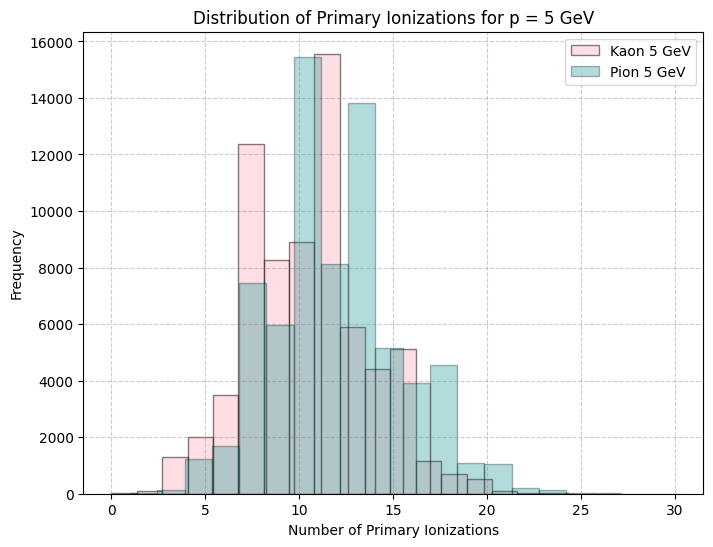

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.hist(np.sum(kaon_momentum_subsets[5.0]['tag_values'] == 1, axis=1), bins=20, edgecolor='black', alpha=0.5, label='Kaon 5 GeV', color = 'pink')
plt.hist(np.sum(pion_momentum_subsets[5.0]['tag_values'] == 1, axis=1)[:70000], bins=20, edgecolor='black', alpha=0.3, label='Pion 5 GeV', color = 'darkcyan')
plt.xlabel('Number of Primary Ionizations')
plt.ylabel('Frequency')
plt.title('Distribution of Primary Ionizations for p = 5 GeV')
plt.legend()
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.savefig('distrubtion.png')

# FCA, ACA, Ideal, Model

### FCA ACA Ideal

In [59]:
# best for ACA & FCA
T1 = 0.0759587
T2 = 0.053320

# best for D2 + model - actually not anymore! these values were calculated using a faulty version of D2, scroll down for correct values
# T1 = 0.0411
# T2 = 0.0779

In [67]:
pion_momenta, mean_pion_FCA, std_pion_FCA = process_momentum_subsets_FCA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=5000
)

kaon_momenta, mean_kaon_FCA, std_kaon_FCA = process_momentum_subsets_FCA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=5000
)

pion_momenta, mean_pion_ACA, std_pion_ACA = process_momentum_subsets_ACA(
    pion_momentum_subsets, "Pion", T1, T2, max_events=5000
)

kaon_momenta, mean_kaon_ACA, std_kaon_ACA = process_momentum_subsets_ACA(
    kaon_momentum_subsets, "Kaon", T1, T2, max_events=5000
)

Processing Pion momentum 5.0 GeV: 5000 events
  Mean: 11.061, Std: 2.778
Processing Pion momentum 7.5 GeV: 5000 events
  Mean: 11.435, Std: 2.756
Processing Pion momentum 10.0 GeV: 5000 events
  Mean: 11.640, Std: 2.741
Processing Pion momentum 12.5 GeV: 5000 events
  Mean: 11.805, Std: 2.739
Processing Pion momentum 15.0 GeV: 5000 events
  Mean: 11.885, Std: 2.701
Processing Pion momentum 17.5 GeV: 5000 events
  Mean: 11.941, Std: 2.706
Processing Pion momentum 20.0 GeV: 5000 events
  Mean: 11.960, Std: 2.713
Processing Kaon momentum 5.0 GeV: 5000 events
  Mean: 10.187, Std: 2.907
Processing Kaon momentum 7.5 GeV: 5000 events
  Mean: 10.540, Std: 2.927
Processing Kaon momentum 10.0 GeV: 5000 events
  Mean: 10.827, Std: 2.843
Processing Kaon momentum 12.5 GeV: 5000 events
  Mean: 10.980, Std: 2.865
Processing Kaon momentum 15.0 GeV: 5000 events
  Mean: 11.146, Std: 2.829
Processing Kaon momentum 17.5 GeV: 5000 events
  Mean: 11.233, Std: 2.829
Processing Kaon momentum 20.0 GeV: 5000 ev

In [47]:
mean_pion, std_pion = process_momentum_subsets_TRUTH(pion_momentum_subsets, 50000)
mean_kaon, std_kaon = process_momentum_subsets_TRUTH(kaon_momentum_subsets, 50000)

### Model

In [ ]:
import keras
model = keras.models.load_model("models/unnormalized_binary.keras")

mean_pion_binary, std_pion_binary = process_momentum_subsets_CLASSIFIER(
    pion_momentum_subsets,
    model=model,  # Replace with your binary classifier model
    max_events=5000
)

mean_kaon_binary, std_kaon_binary = process_momentum_subsets_CLASSIFIER(
    kaon_momentum_subsets,
    model=model,  # Replace with your binary classifier model
    max_events=5000
)

157/157 [==============================] - 1s 4ms/step


In [6]:
T1 = 0.0521
T2 = 0.0779

peaks = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)

In [10]:
lens = []

for peak in peaks:
    lens.append(len(peak))

In [14]:
np.max(lens)

252

In [35]:
import tensorflow
import keras
T1 = 0.0521
T2 = 0.0779
model = keras.models.load_model('models/500_ml_on_peaks_regressor_no_amp_0.0521_0.0779.keras')

mean_pion_d2_peak_CNN, std_pion_d2_peak_CNN = process_momentum_subsets_D2_MODEL_ONLY_PEAKS(pion_momentum_subsets, model, 50000, T1=T1, T2=T2)
mean_kaon_d2_peak_CNN, std_kaon_d2_peak_CNN = process_momentum_subsets_D2_MODEL_ONLY_PEAKS(kaon_momentum_subsets, model, 50000, T1=T1, T2=T2)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 590us/step
[12.099812  16.116262   9.203819  ... 11.071509  15.736212  15.2519245]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 585us/step
[15.542425  11.500803  12.804918  ... 11.965405   9.433287  15.7105465]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0
1563/1563 [==============================] - 1s 586us/step
[ 9.623982 13.707433 11.047642 ...  8.695716  8.209232 14.460214]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0

In [1]:
import keras

2025-08-20 00:24:40.027284: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-20 00:24:40.046473: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
testdata = {d:testdata[d][:1000] for d in testdata}

In [10]:
peak_times_test = numba_batched_derivative_peak_detection(testdata['wf_i'], T1, T2)

In [ ]:
peak_data_test = np.zeros((len(peak_times_test), num_timepoints), dtype=np.float32)
for i, peaks in enumerate(peak_times_test):
    for peak in peaks:
        peak_data_test[i, peak] = 1.0
        # peak_data_test[i, peak] = testdata['wf_i'][i, peak]

In [12]:
target_test = np.zeros([testdata['wf_i'].shape[0], 3000])
target_test[np.where(testdata['tag_values'] == 1)[0], testdata['tag_times'][np.where(testdata['tag_values'] == 1)]] = testdata['wf_i'][np.where(testdata['tag_values'] == 1)[0], testdata['tag_times'][np.where(testdata['tag_values'] == 1)]]

In [57]:
model = keras.models.load_model('models/ml_on_peaks_regressor_d2_no_amplitude_info_0.0411_0.0779.keras')

In [22]:
model_paths = ['models/500_dense_8_32_8_lr=6e-4.keras', 
               'models/0.8_pruned_500_dense_8_32_8_lr=6e-4.keras',
               'models/8_2_0.8_pruned_500_dense_8_32_8_lr=6e-4.h5']

In [11]:
import keras
from qkeras.utils import _add_supported_quantized_objects
co = {}
_add_supported_quantized_objects(co)
model = keras.models.load_model('models/8_2_0.8_pruned_500_dense_8_32_8_lr=4e-4.h5', custom_objects=co)

2025-08-26 08:05:20.111610: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-26 08:05:21.354581: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
mean_pion_model, std_pion_model = process_momentum_subsets_MODEL(pion_momentum_subsets, model, 50000)
mean_kaon_model, std_kaon_model = process_momentum_subsets_MODEL(kaon_momentum_subsets, model, 50000)

kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
kp_separation_MODEL_scaled = kp_separation_MODEL


1563/1563 [==============================] - 1s 341us/step


In [13]:
kp_separation_MODEL

array([0.33181047, 0.31663352, 0.32958522, 0.30342707, 0.27342352,
       0.24976067, 0.2313896 ], dtype=float32)

In [25]:
import keras
len_scaler = 10
for model_path in model_paths:
    print(f"\nLoading model from {model_path}")
    if model_path.endswith('.keras'):
        model = keras.models.load_model(model_path)  
    
    else:
        from qkeras.utils import _add_supported_quantized_objects
        co = {}
        _add_supported_quantized_objects(co)
        model = keras.models.load_model(model_path, custom_objects=co)

    mean_pion_model, std_pion_model = process_momentum_subsets_MODEL(pion_momentum_subsets, model, 50000)
    mean_kaon_model, std_kaon_model = process_momentum_subsets_MODEL(kaon_momentum_subsets, model, 50000)

    kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
    kp_separation_MODEL_scaled = kp_separation_MODEL

    print(kp_separation_MODEL_scaled)

    


Loading model from models/500_dense_8_32_8_lr=6e-4.keras
1563/1563 [==============================] - 0s 274us/step
[0.34553888 0.3317395  0.34120497 0.31628186 0.28303164 0.26045817
 0.24353632]

Loading model from models/0.8_pruned_500_dense_8_32_8_lr=6e-4.keras
1563/1563 [==============================] - 0s 273us/step
[0.3386565  0.32316285 0.33251214 0.30541086 0.27708793 0.2567166
 0.23836961]

Loading model from models/8_2_0.8_pruned_500_dense_8_32_8_lr=6e-4.h5


1563/1563 [==============================] - 1s 342us/step
[0.32469207 0.3127808  0.320665   0.29667974 0.2690388  0.24589393
 0.16980648]


# KP Separation

In [68]:
# len_scaler = np.sqrt(1000/(9*np.sqrt(1)))
len_scaler = 10

kp_separation_FCA = np.abs(mean_pion_FCA - mean_kaon_FCA) / ((std_pion_FCA + std_kaon_FCA)/2)
kp_separation_FCA_scaled = kp_separation_FCA * len_scaler

print(f"\nSeparation Power FCA: {kp_separation_FCA}")
print(f"\nSeparation Power FCA scaled: {kp_separation_FCA_scaled}")

kp_separation_ACA = np.abs(mean_pion_ACA - mean_kaon_ACA) / ((std_pion_ACA + std_kaon_ACA)/2)
kp_separation_ACA_scaled = kp_separation_ACA * len_scaler

print(f"\nSeparation Power ACA: {kp_separation_ACA}")
print(f"\nSeparation Power ACA scaled: {kp_separation_ACA_scaled}")

# kp_separation_TRUTH = np.abs(mean_pion - mean_kaon) / ((std_pion + std_kaon)/2)
# kp_separation_TRUTH_scaled = kp_separation_TRUTH * len_scaler

# print(f"\nSeparation Power TRUTH: {kp_separation_TRUTH}")
# print(f"\nSeparation Power TRUTH scaled: {kp_separation_TRUTH_scaled}")

# kp_separation_MODEL = np.abs(mean_pion_model - mean_kaon_model) / ((std_pion_model + std_kaon_model)/2)
# kp_separation_MODEL_scaled = kp_separation_MODEL * len_scaler

# print(f"\nSeparation Power MODEL: {kp_separation_MODEL}")
# print(f"\nSeparation Power MODEL scaled: {kp_separation_MODEL_scaled}")

# kp_separation_BINARY = np.abs(mean_pion_binary - mean_kaon_binary) / ((std_pion_binary + std_kaon_binary)/2)
# kp_separation_BINARY_scaled = kp_separation_BINARY * len_scaler 

# print(f"\nSeparation Power BINARY: {kp_separation_BINARY}")
# print(f"\nSeparation Power BINARY scaled: {kp_separation_BINARY_scaled}")

# kp_separation_Peak_CNN = np.abs(mean_pion_peak_CNN - mean_kaon_peak_CNN) / ((std_pion_peak_CNN + std_kaon_peak_CNN)/2)
# kp_separation_Peak_CNN_scaled = kp_separation_Peak_CNN * len_scaler

# print(f"\nSeparation Power Peak CNN: {kp_separation_Peak_CNN}")
# print(f"\nSeparation Power Peak CNN scaled: {kp_separation_Peak_CNN_scaled}")

# kp_separation_D2_Peak_CNN = np.abs(mean_pion_d2_peak_CNN - mean_kaon_d2_peak_CNN) / ((std_pion_d2_peak_CNN + std_kaon_d2_peak_CNN)/2)
# kp_separation_D2_Peak_CNN_scaled = kp_separation_D2_Peak_CNN * len_scaler

# print(f"\nSeparation Power D2 Peak CNN: {kp_separation_D2_Peak_CNN}")
# print(f"\nSeparation Power D2 Peak CNN scaled: {kp_separation_D2_Peak_CNN_scaled}")

# kp_separation_D2_Peak_Amp_CNN = np.abs(mean_pion_d2_peak_amp_CNN - mean_kaon_d2_peak_amp_CNN) / ((std_pion_d2_peak_amp_CNN + std_kaon_d2_peak_amp_CNN)/2)
# kp_separation_D2_Peak_Amp_CNN_scaled = kp_separation_D2_Peak_Amp_CNN * len_scaler

# print(f"\nSeparation Power D2 Peak Amp CNN: {kp_separation_D2_Peak_Amp_CNN}")
# print(f"\nSeparation Power D2 Peak Amp CNN scaled: {kp_separation_D2_Peak_Amp_CNN_scaled}")




Separation Power FCA: [0.30724589 0.31504556 0.29123308 0.2944845  0.2670068  0.25560569
 0.23954711]

Separation Power FCA scaled: [3.07245893 3.15045558 2.91233079 2.94484501 2.67006804 2.55605691
 2.39547113]

Separation Power ACA: [0.32676041 0.34233735 0.31363837 0.29698376 0.26228995 0.26701041
 0.23719099]

Separation Power ACA scaled: [3.26760407 3.42337353 3.13638365 2.9698376  2.6228995  2.67010407
 2.37190986]


In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Plot

### Truncated

In [2]:
import numpy as np
# this commented out one is with 5k events, new is with 50k
# # kp_separation_FCA = [0.3188143, 0.30275777, 0.30625865, 0.28642918, 0.25283781, 0.24258478, 0.2304698]
kp_separation_FCA = [0.33156225, 0.31442311, 0.30893409, 0.28772187, 0.25873172, 0.2411576, 0.22315598]
# # this commented out one is with 5k events, new is with 50k
# # kp_separation_ACA = [0.33187366, 0.32558779, 0.31819752, 0.29730798, 0.27362652, 0.25344958, 0.23244403]
kp_separation_ACA = [0.32844014, 0.324104, 0.31813191, 0.29159882, 0.27064629, 0.2506275, 0.22695639]
# this one is with wrong region bounds!
# kp_separation_ACA = [0.33187366, 0.32558779, 0.31819752, 0.29730798, 0.27362652, 0.25344958, 0.23244403]
kp_separation_TRUTH = [0.46805582, 0.45660283, 0.45609252, 0.42223516, 0.38629371, 0.34968446, 0.3134905]

kp_separation_DNN = [0.34553888, 0.3317395, 0.34120497, 0.31628186, 0.28303164, 0.26045817, 0.24353632]
kp_separation_80_DNN = [0.3386565, 0.32316285, 0.33251214, 0.30541086, 0.27708793, 0.2567166, 0.23836961]
kp_separation_8_2_80_DNN = [0.32469207, 0.3127808, 0.320665, 0.29667974, 0.2690388, 0.24589393, 0.16980648]
kp_separation_D2_Peak_CNN = [0.36609158, 0.35222098, 0.3520589, 0.32866433, 0.29910764, 0.2745501, 0.25246462]

kp_separation_8_2_80_DNN = [0.33181047, 0.31663352, 0.32958522, 0.30342707, 0.27342352,
       0.24976067, 0.2313896 ]
kp_separation_FCA = np.asarray(kp_separation_FCA)
kp_separation_ACA = np.asarray(kp_separation_ACA)
kp_separation_TRUTH = np.asarray(kp_separation_TRUTH)
kp_separation_DNN = np.asarray(kp_separation_DNN)
kp_separation_80_DNN = np.asarray(kp_separation_80_DNN)
kp_separation_8_2_80_DNN = np.asarray(kp_separation_8_2_80_DNN)
kp_separation_D2_Peak_CNN = np.asarray(kp_separation_D2_Peak_CNN)

momenta = [5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]

In [3]:
import numpy as np

kp_separation_DNN_hls = [0.26475042, 0.24024563, 0.24249125, 0.21606722, 0.18382579, 0.16592906, 0.1650099 ]

kp_separation_80_DNN_hls = [0.33171684, 0.31565264, 0.3211001 , 0.29665107, 0.26939324,
       0.24562043, 0.2307306 ]

kp_separation_8_2_80_DNN_hls = [0.31811315, 0.30857185, 0.3097894 , 0.28975704, 0.2584799, 0.23578228, 0.22581804]

kp_16_5_hls = [0.341388  , 0.32717508, 0.3363875 , 0.31014034, 0.2762011 ,
       0.2575752 , 0.23889536]
kp_16_5_0_6_pruned_hls = [0.33977747, 0.3310822 , 0.33450463, 0.3090916 , 0.27928016, 0.25720903, 0.23954436]
kp_10_5_0_6_pruned_hls = [0.34429792, 0.3276877 , 0.33450112, 0.31061912, 0.27586433, 0.2588253 , 0.239413  ]
kp_10_5_0_8_pruned_hls = [0.32525465, 0.31269225, 0.3210967 , 0.29134598, 0.26494724,
       0.24221613, 0.22904702]

kp_10_5_hls = [0.34691727, 0.3330357 , 0.34003016, 0.31206596, 0.27897048,
       0.26003128, 0.24141768]

kp_16_5_hls = np.asarray(kp_16_5_hls)
kp_16_5_0_6_pruned_hls = np.asarray(kp_16_5_0_6_pruned_hls)
kp_10_5_0_6_pruned_hls = np.asarray(kp_10_5_0_6_pruned_hls)
kp_10_5_0_8_pruned_hls = np.asarray(kp_10_5_0_8_pruned_hls)
kp_10_5_hls = np.asarray(kp_10_5_hls)

len_scaler = 10




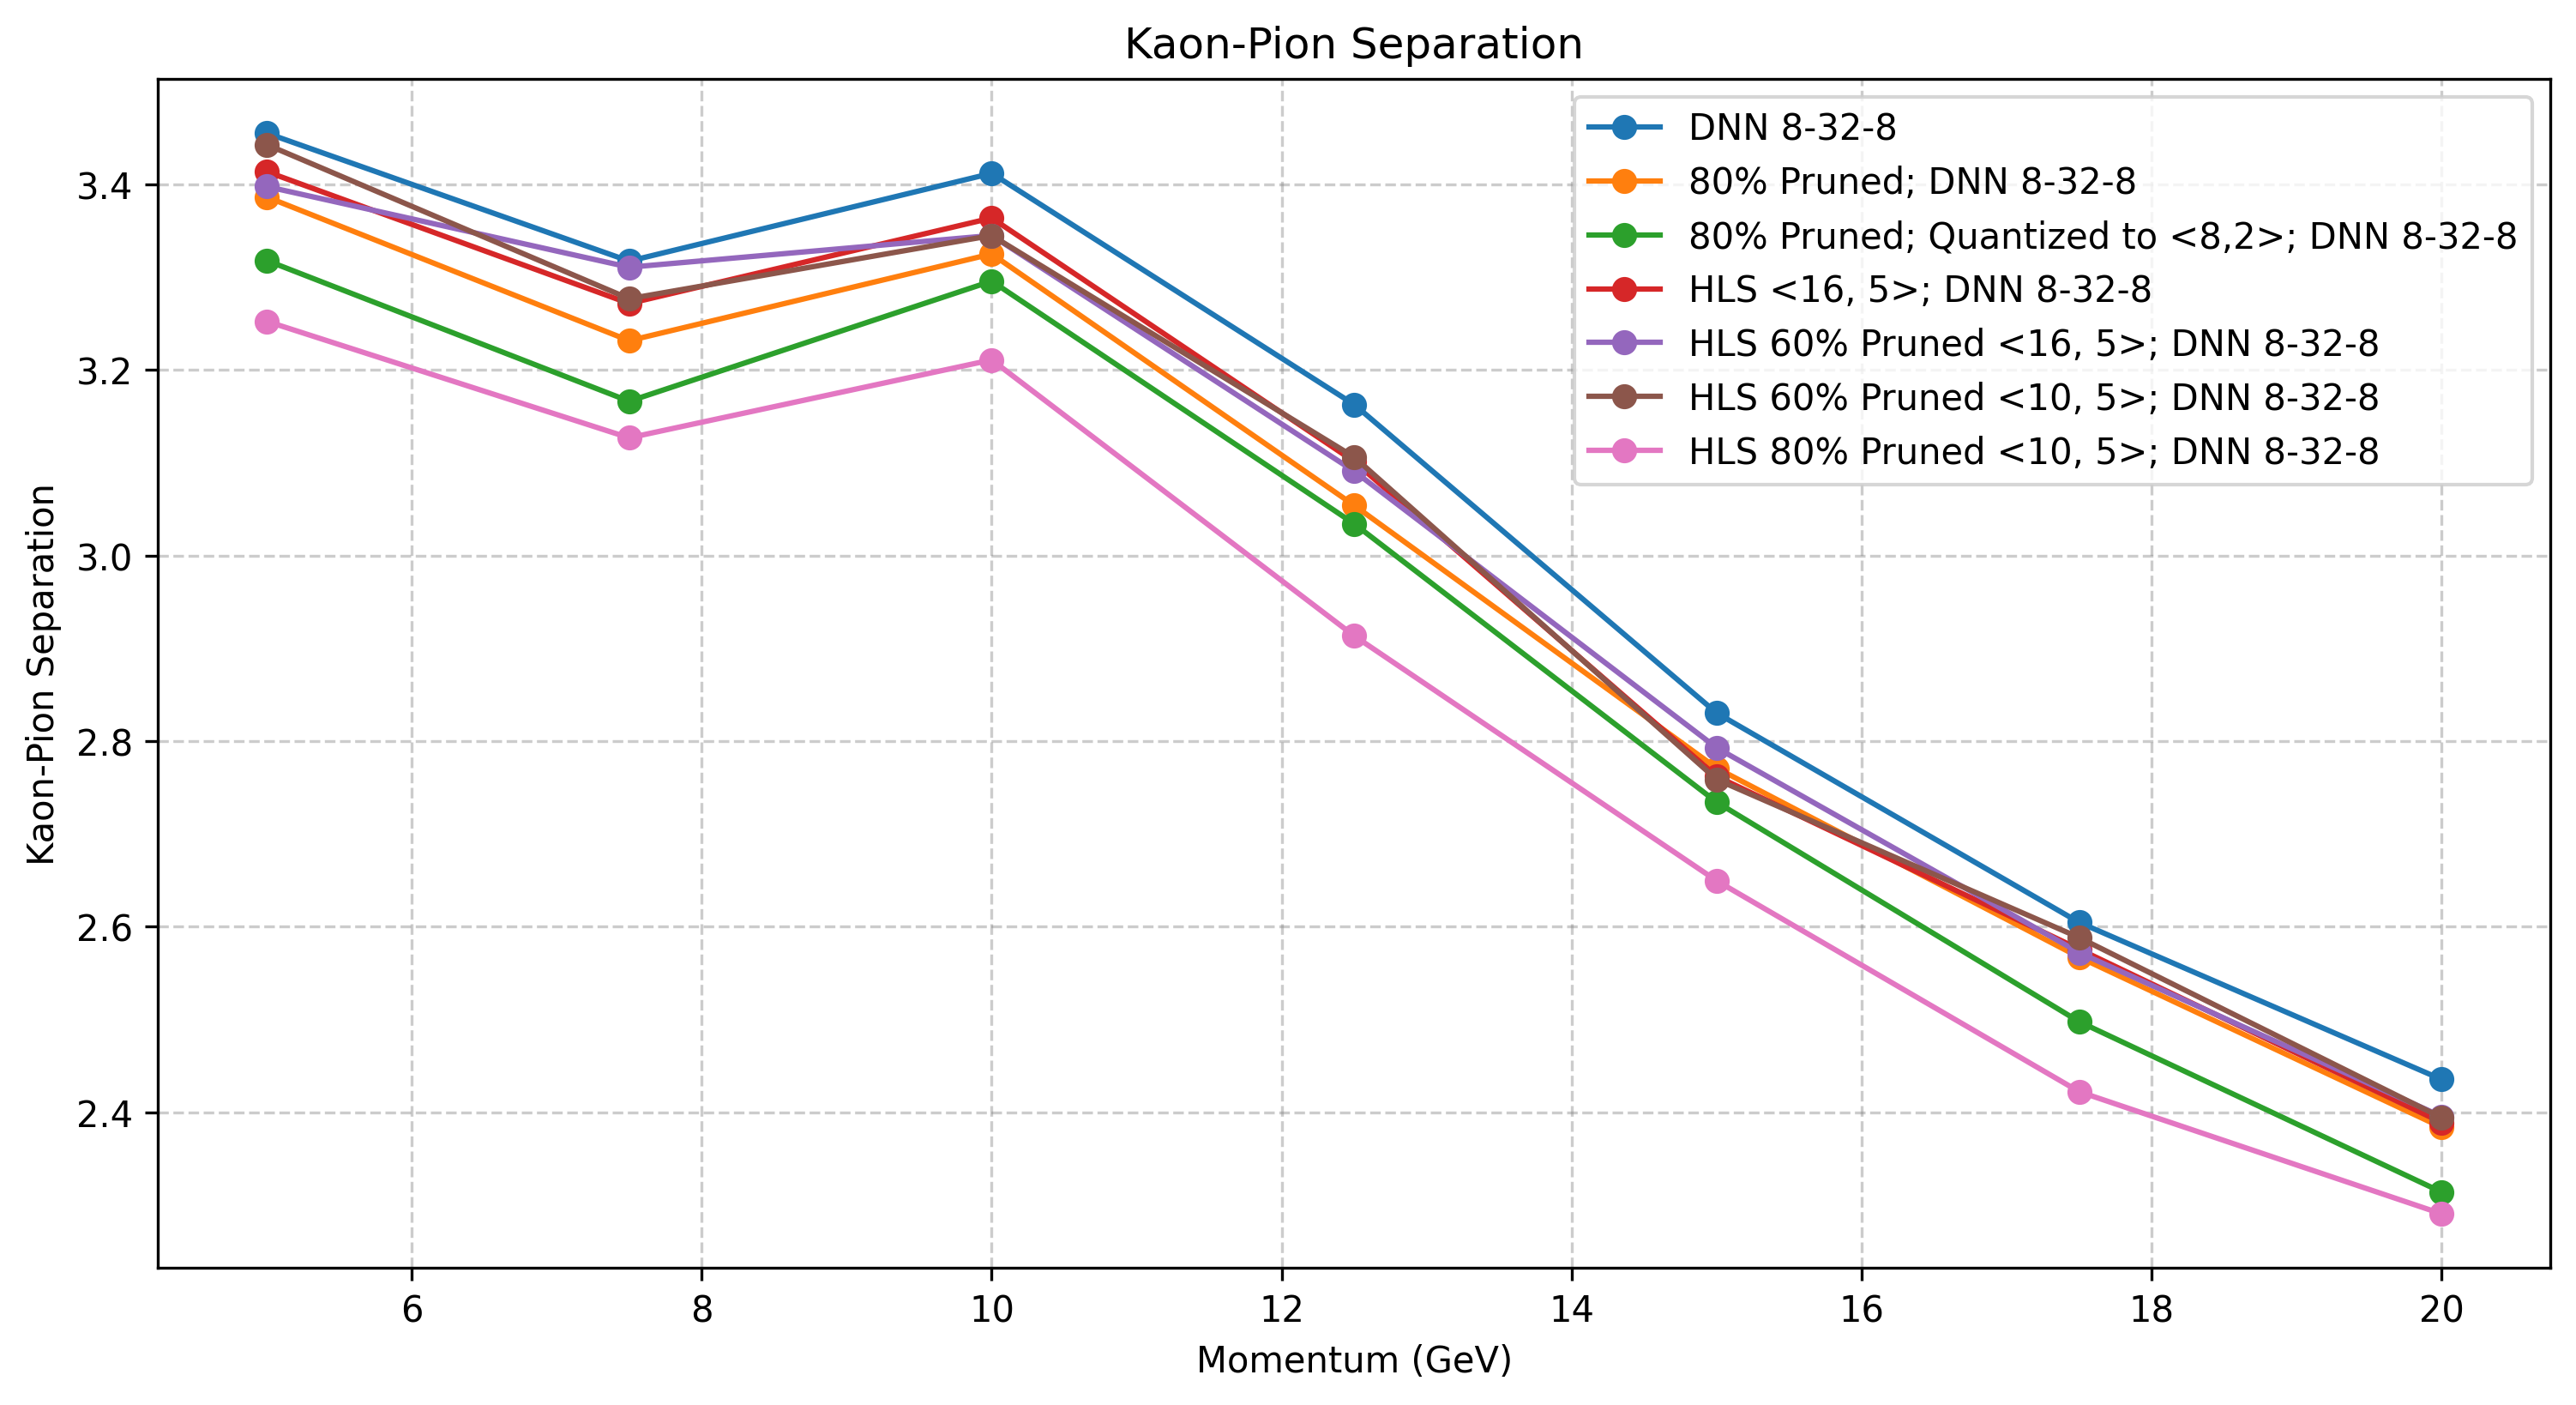

In [4]:
import matplotlib.pyplot as plt

len_scaler = 10

plt.figure(figsize=(12, 6), dpi=300)

plt.plot(momenta, np.asarray(kp_separation_DNN) * len_scaler, '-o', label = 'DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_separation_80_DNN) * len_scaler, '-o', label = '80% Pruned; DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_separation_8_2_80_DNN) * len_scaler, '-o', label = '80% Pruned; Quantized to <8,2>; DNN 8-32-8')

plt.plot(momenta, np.asarray(kp_16_5_hls) * len_scaler, '-o', label = 'HLS <16, 5>; DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_16_5_0_6_pruned_hls) * len_scaler, '-o', label = 'HLS 60% Pruned <16, 5>; DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_10_5_0_6_pruned_hls) * len_scaler, '-o', label = 'HLS 60% Pruned <10, 5>; DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_10_5_0_8_pruned_hls) * len_scaler, '-o', label = 'HLS 80% Pruned <10, 5>; DNN 8-32-8')

plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.xlabel('Momentum (GeV)')
plt.ylabel('Kaon-Pion Separation')
plt.legend()
plt.title('Kaon-Pion Separation')
plt.savefig('kaon_pion_50k.png')

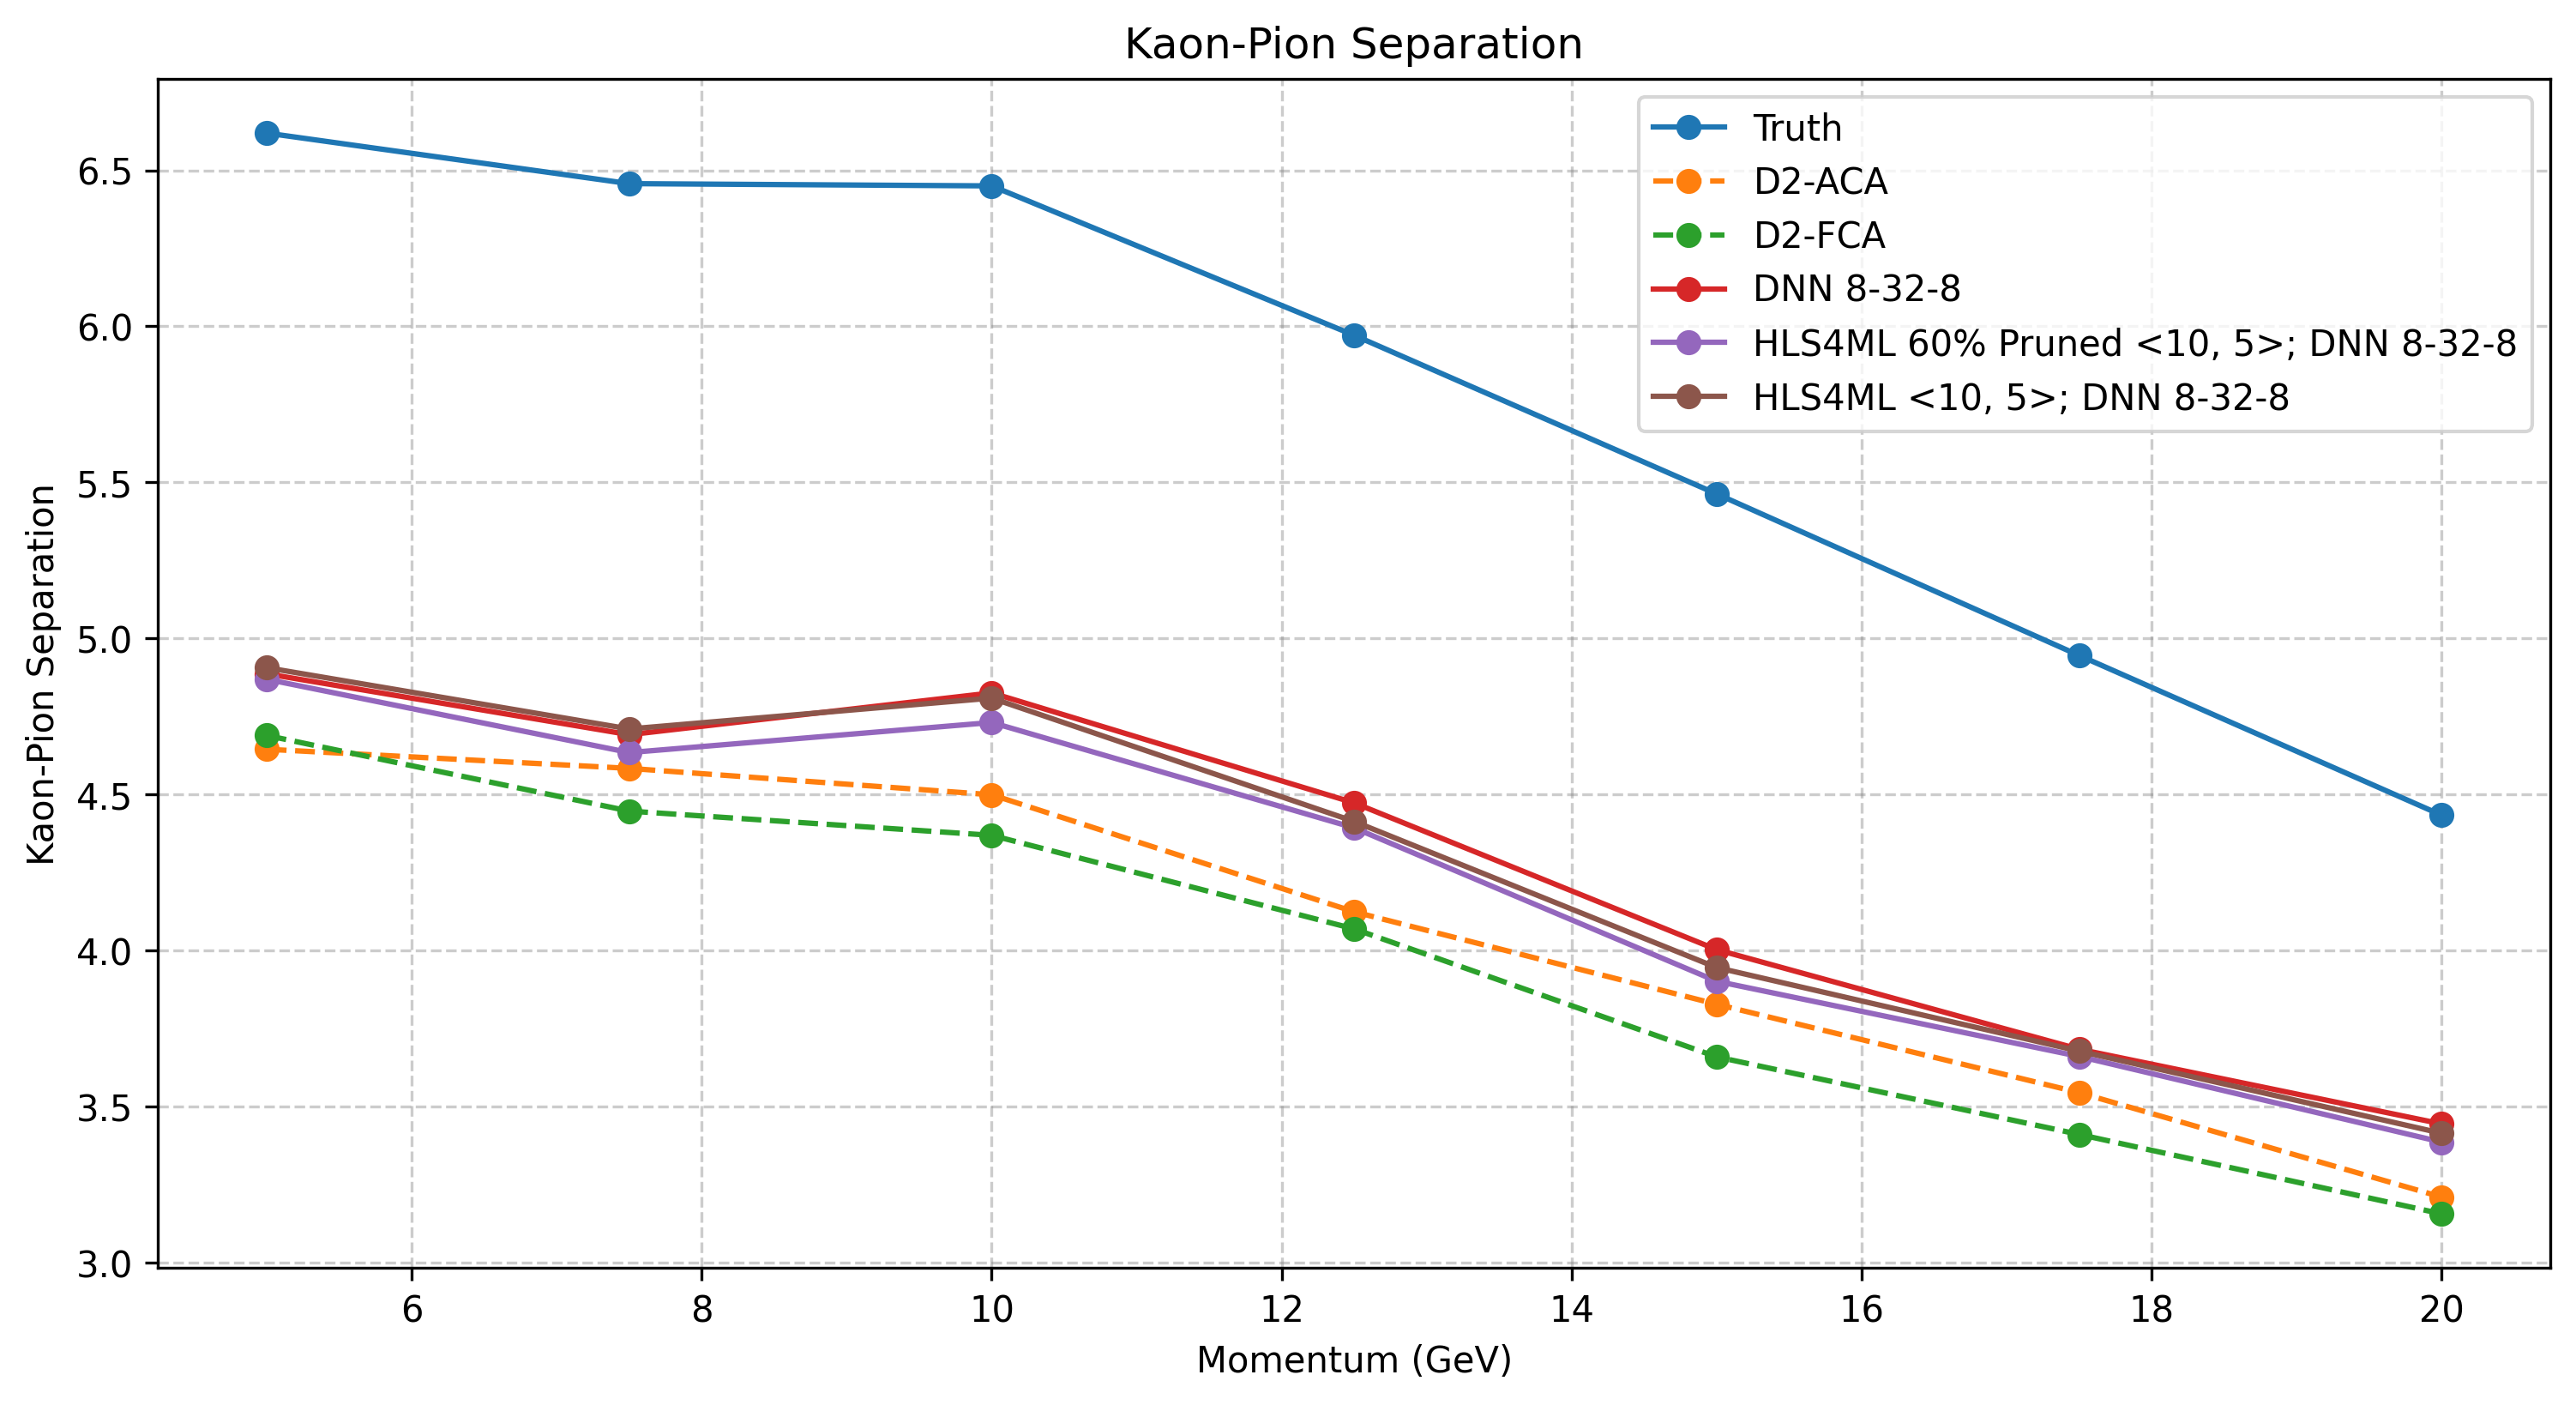

In [7]:
import matplotlib.pyplot as plt
import math

len_scaler = 10 * math.sqrt(2)

plt.figure(figsize=(12, 6), dpi=300)
plt.plot(momenta, kp_separation_TRUTH * len_scaler, '-o', label = 'Truth')
plt.plot(momenta, kp_separation_ACA * len_scaler, '--o', label = 'D2-ACA')
plt.plot(momenta, kp_separation_FCA * len_scaler, '--o', label = 'D2-FCA')
# plt.plot(momenta, kp_separation_BINARY * len_scaler, '-o', label = 'Binary Classifier')
# plt.plot(momenta, kp_separation_Peak_CNN * len_scaler, '-o', label = 'Truth Peak Info + CNN Regressor')
# plt.plot(momenta, kp_separation_D2_Peak_CNN * len_scaler, '-o', label = 'D2 + CNN Regressor')
# plt.plot(momenta, kp_separation_D2_Peak_Amp_CNN * len_scaler, '-o', label = 'D2 + Amp + CNN Regressor')
plt.plot(momenta, np.asarray(kp_separation_DNN) * len_scaler, '-o', label = 'DNN 8-32-8')
# plt.plot(momenta, np.asarray(kp_separation_80_DNN) * len_scaler, '-o', label = '80% Pruned; DNN 8-32-8')
# plt.plot(momenta, np.asarray(kp_separation_8_2_80_DNN) * len_scaler, '-o', label = '80% Pruned; Quantized to <8,2>; DNN 8-32-8')

# plt.plot(momenta, np.asarray(kp_16_5_hls) * len_scaler, '-o', label = 'HLS <16, 5>; DNN 8-32-8')
# plt.plot(momenta, np.asarray(kp_16_5_0_6_pruned_hls) * len_scaler, '-o', label = 'HLS 60% Pruned <16, 5>; DNN 8-32-8')


plt.plot(momenta, np.asarray(kp_10_5_0_6_pruned_hls) * len_scaler, '-o', label = 'HLS4ML 60% Pruned <10, 5>; DNN 8-32-8')
plt.plot(momenta, np.asarray(kp_10_5_hls) * len_scaler, '-o', label = 'HLS4ML <10, 5>; DNN 8-32-8')
# plt.plot(momenta, np.asarray(kp_10_5_0_8_pruned_hls) * len_scaler, '-o', label = 'HLS 80% Pruned <10, 5>; DNN 8-32-8')


plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.xlabel('Momentum (GeV)')
plt.ylabel('Kaon-Pion Separation')
plt.legend()
plt.title('Kaon-Pion Separation')
plt.savefig('kaon_pion_50k.png')

### Full waveform

In [15]:
kp_separation_FCA = [0.37885505,0.4048259,0.38449916,0.37299404,0.36216123,0.33233918,0.29229119]
kp_separation_ACA = [0.45224741,0.48288111,0.43828864,0.44797488,0.41330219,0.3682119,0.34267554]
kp_separation_TRUTH = [0.6834794,0.6844546,0.65113287,0.64164077,0.58212681,0.51945811,0.46358255]
kp_separation_MODEL = [0.55023587,0.5709394,0.53887725,0.5392213,0.48902717,0.4524766,0.3826344]
kp_separation_BINARY = [0.48985027, 0.51376222, 0.46972027, 0.46380324, 0.42576171, 0.41066501, 0.33101631]
kp_separation_Peak_CNN = [0.554254, 0.5864291, 0.54926825, 0.54140496, 0.49052435, 0.45426202, 0.3815242]

# this is with 0.07 0.06
# kp_separation_D2_Peak_CNN = [0.49065828, 0.48334718, 0.45485204, 0.45965266, 0.41720805, 0.38999236, 0.33899087]
# kp_separation_D2_Peak_Amp_CNN = [0.5022699, 0.50061536, 0.47116888, 0.48240942, 0.4313987, 0.41176075, 0.35097674]

# this is with 0.0411 0.0779
kp_separation_D2_Peak_Amp_CNN = [0.49791938, 0.5270239, 0.4723663, 0.48765543, 0.4351886, 0.42018798, 0.35600764]
kp_separation_D2_Peak_CNN = [0.49312553, 0.5214386, 0.4636665, 0.479633, 0.4276603, 0.4130282, 0.34670973]

kp_separation_FCA = np.asarray(kp_separation_FCA)
kp_separation_ACA = np.asarray(kp_separation_ACA)
kp_separation_TRUTH = np.asarray(kp_separation_TRUTH)
kp_separation_MODEL = np.asarray(kp_separation_MODEL)
kp_separation_BINARY = np.asarray(kp_separation_BINARY)
kp_separation_Peak_CNN = np.asarray(kp_separation_Peak_CNN)
kp_separation_D2_Peak_CNN = np.asarray(kp_separation_D2_Peak_CNN)
kp_separation_D2_Peak_Amp_CNN = np.asarray(kp_separation_D2_Peak_Amp_CNN)

momenta = [5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. ]

NameError: name 'kp_separation_Peak_CNN' is not defined

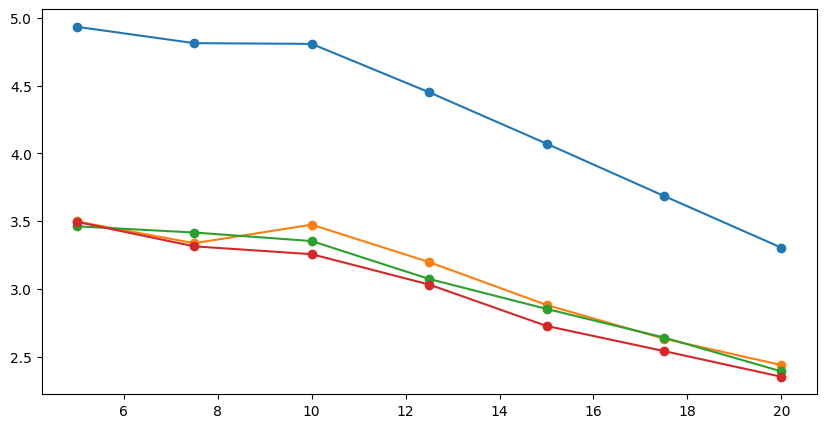

In [ ]:
import matplotlib.pyplot as plt

len_scaler = np.sqrt(1000/(9*np.sqrt(1)))

plt.figure(figsize=(10, 5))
plt.plot(momenta, kp_separation_TRUTH * len_scaler, '-o', label = 'Truth')
plt.plot(momenta, kp_separation_MODEL * len_scaler, '-o', label = 'Best Accuracy CNN Regressor')
plt.plot(momenta, kp_separation_ACA * len_scaler, '-o', label = 'D2-ACA')
plt.plot(momenta, kp_separation_FCA * len_scaler, '-o', label = 'D2-FCA')
# plt.plot(momenta, kp_separation_BINARY * len_scaler, '-o', label = 'Binary Classifier')
# plt.plot(momenta, kp_separation_Peak_CNN * len_scaler, '-o', label = 'Truth Peak Info + CNN Regressor')
# plt.plot(momenta, kp_separation_D2_Peak_CNN * len_scaler, '-o', label = 'D2 + CNN Regressor')
plt.plot(momenta, kp_separation_D2_Peak_Amp_CNN * len_scaler, '-o', label = 'D2 + Amp + CNN Regressor')
plt.grid(True, color='gray', linestyle='--', alpha=0.4)
plt.xlabel('Momentum (GeV)')
plt.ylabel('Kaon-Pion Separation')
plt.legend()
plt.title('Kaon-Pion Separation')